ライブラリのインポート

In [0]:
import chainer
import chainer.links as L
import chainer.functions as F 

import numpy as np
import math
import random
import matplotlib.pyplot as plt

In [0]:
from chainer import optimizers, cuda
import cupy as xp
import time
import sys
import pickle

乱数のシード指定

In [0]:
random.seed(0)

訓練データ生成クラス

In [0]:
class DataMaker(object):
  
    def __init__(self, steps_per_cycle, number_of_cycles):
        self.steps_per_cycle = steps_per_cycle
        self.number_of_cycles = number_of_cycles
 
    def make(self):
        return np.array([math.sin(i * 2 * math.pi/self.steps_per_cycle) for i in range(self.steps_per_cycle)] * self.number_of_cycles)
 
    def make_mini_batch(self, data, mini_batch_size, length_of_sequence):
        sequences = np.ndarray((mini_batch_size, length_of_sequence), dtype=np.float32)#mini_batch_size行length_of_sequence列の配列を生成
        for i in range(mini_batch_size):
            index = random.randint(0, len(data) - length_of_sequence)
            sequences[i] = data[index:index+length_of_sequence]
        return sequences

In [0]:
jin1 = DataMaker(100, 2)

In [0]:
data1 = jin1.make()

In [0]:
data1_1 = jin1.make_mini_batch(data1, 10, 20)

ネットワークの構成

In [0]:
class LSTM(chainer.Chain):
 
    def __init__(self, in_units=1, hidden_units=2, out_units=1, train=True):
        super(LSTM, self).__init__(
            l1=L.Linear(in_units, hidden_units),
            l2=L.LSTM(hidden_units, hidden_units),
            l3=L.Linear(hidden_units, out_units),
        )   
        self.train = True
 
    def __call__(self, x, t): 
        h = self.l1(x)
        h = self.l2(h)
        y = self.l3(h)
        self.loss = F.mean_squared_error(y, t)
        if self.train:
            return self.loss
        else:
            self.prediction = y 
            return self.prediction
 
    def reset_state(self):
        self.l2.reset_state()

パラメータ設定

In [0]:
IN_UNITS = 1
HIDDEN_UNITS = 5
OUT_UNITS = 1
TRAINING_EPOCHS = 50
DISPLAY_EPOCH = 10
MINI_BATCH_SIZE = 100
LENGTH_OF_SEQUENCE = 100
STEPS_PER_CYCLE = 50
NUMBER_OF_CYCLES = 100

loss計算関数

In [0]:
def compute_loss(model, sequences):
    loss = 0
    rows, cols = sequences.shape#rowがバッチサイズ、colsが連続データ数
    length_of_sequence = cols
    for i in range(cols - 1):#cols-1時刻分ループすることですべてのバッチで学習が終わる
        x = chainer.Variable(
            xp.asarray(
                [sequences[j, i + 0] for j in range(rows)], #各バッチの頭から取り出していって列の形状にする。時系列的な関連性はない。全部同時に入れるイメージ
                dtype=np.float32
            )[:, np.newaxis]
        )
        t = chainer.Variable(
            xp.asarray(
                [sequences[j, i + 1] for j in range(rows)], #各バッチの頭よりも1時刻先から取り出していって列の形状にする。時系列的な関連性はない。全部同時に入れるイメージ
                dtype=np.float32
            )[:, np.newaxis]
        )
        loss += model(x, t)#バッチサイズがいくつでも帰ってくるのは配列ではなく変数
    return loss 

更新部分

In [12]:
# make training data
data_maker = DataMaker(steps_per_cycle=STEPS_PER_CYCLE, number_of_cycles=NUMBER_OF_CYCLES)
train_data = data_maker.make()

# setup model
model = LSTM(IN_UNITS, HIDDEN_UNITS, OUT_UNITS)
for param in model.params():
    data = param.data
    data[:] = np.random.uniform(-0.1, 0.1, data.shape)

model.to_gpu()

# setup optimizer
optimizer = chainer.optimizers.Adam()#chainer.がないと動かない。
optimizer.setup(model)

start = time.time()
cur_start = start
for epoch in range(TRAINING_EPOCHS):
    sequences = data_maker.make_mini_batch(train_data, mini_batch_size=MINI_BATCH_SIZE, length_of_sequence=LENGTH_OF_SEQUENCE)
    model.reset_state()
    model.zerograds()
    loss = compute_loss(model, sequences)
    loss.backward()
    optimizer.update()

    if epoch != 0 and epoch % DISPLAY_EPOCH == 0:
        cur_end = time.time()
        # display loss
        print(
            "[{j}]training loss:\t{i}\t{k}[sec/epoch]".format(
                j=epoch, 
                i=loss.data/(sequences.shape[1] - 1), #compute loss関数より、for cols -1なのでその分割っている
                k=(cur_end - cur_start)/DISPLAY_EPOCH
            )
        )
        cur_start = time.time() 
        sys.stdout.flush()

end = time.time()

print("{}[sec]".format(end - start))

[10]training loss:	0.5015531	0.8609073400497437[sec/epoch]
[20]training loss:	0.49958736	0.3807653903961182[sec/epoch]
[30]training loss:	0.49869025	0.38219761848449707[sec/epoch]
[40]training loss:	0.49692783	0.3831877946853638[sec/epoch]
23.51863145828247[sec]


In [0]:
#モデルの保存
pickle.dump(model, open("./model.pkl", "wb"))

わかりやすい小規模データインスタンスの作成

In [0]:
P = 2#学習周期
N = 50#正弦波一周期分割数
F = P * N #合計データ数

data_small = DataMaker(steps_per_cycle=N, number_of_cycles=P)

In [0]:
x = np.linspace(0, P * 2 * np.pi, F)#グラフプロット用x軸

makeメソッドでできる配列

In [16]:
plot_data = data_small.make()
print(plot_data)

[ 0.00000000e+00  1.25333234e-01  2.48689887e-01  3.68124553e-01
  4.81753674e-01  5.87785252e-01  6.84547106e-01  7.70513243e-01
  8.44327926e-01  9.04827052e-01  9.51056516e-01  9.82287251e-01
  9.98026728e-01  9.98026728e-01  9.82287251e-01  9.51056516e-01
  9.04827052e-01  8.44327926e-01  7.70513243e-01  6.84547106e-01
  5.87785252e-01  4.81753674e-01  3.68124553e-01  2.48689887e-01
  1.25333234e-01  1.22464680e-16 -1.25333234e-01 -2.48689887e-01
 -3.68124553e-01 -4.81753674e-01 -5.87785252e-01 -6.84547106e-01
 -7.70513243e-01 -8.44327926e-01 -9.04827052e-01 -9.51056516e-01
 -9.82287251e-01 -9.98026728e-01 -9.98026728e-01 -9.82287251e-01
 -9.51056516e-01 -9.04827052e-01 -8.44327926e-01 -7.70513243e-01
 -6.84547106e-01 -5.87785252e-01 -4.81753674e-01 -3.68124553e-01
 -2.48689887e-01 -1.25333234e-01  0.00000000e+00  1.25333234e-01
  2.48689887e-01  3.68124553e-01  4.81753674e-01  5.87785252e-01
  6.84547106e-01  7.70513243e-01  8.44327926e-01  9.04827052e-01
  9.51056516e-01  9.82287

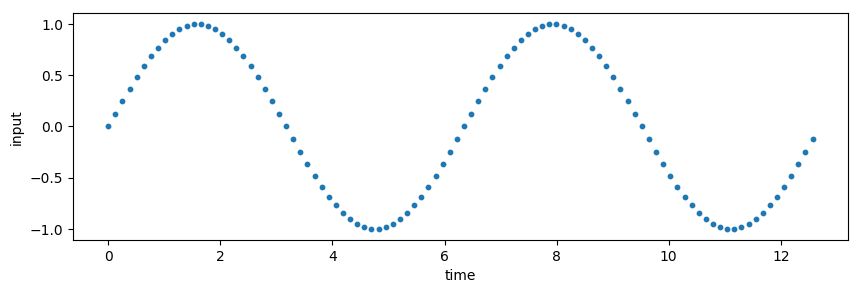

In [17]:
fig = plt.figure(figsize=(10,3), dpi=100, facecolor='w')
ax1 = fig.add_subplot(1,1,1)
plt.xlabel("time")
plt.ylabel("input")
ax1.scatter(x, plot_data, s=10)
plt.show()

make_mini_batchメソッドでできる配列

In [18]:
bat = 5
leng = 20

batch_plot = data_small.make_mini_batch(plot_data, mini_batch_size=bat, length_of_sequence=leng)
print(batch_plot)

[[-2.4868989e-01 -3.6812454e-01 -4.8175368e-01 -5.8778524e-01
  -6.8454713e-01 -7.7051324e-01 -8.4432793e-01 -9.0482706e-01
  -9.5105654e-01 -9.8228723e-01 -9.9802673e-01 -9.9802673e-01
  -9.8228723e-01 -9.5105654e-01 -9.0482706e-01 -8.4432793e-01
  -7.7051324e-01 -6.8454713e-01 -5.8778524e-01 -4.8175368e-01]
 [ 1.2246469e-16 -1.2533323e-01 -2.4868989e-01 -3.6812454e-01
  -4.8175368e-01 -5.8778524e-01 -6.8454713e-01 -7.7051324e-01
  -8.4432793e-01 -9.0482706e-01 -9.5105654e-01 -9.8228723e-01
  -9.9802673e-01 -9.9802673e-01 -9.8228723e-01 -9.5105654e-01
  -9.0482706e-01 -8.4432793e-01 -7.7051324e-01 -6.8454713e-01]
 [ 1.2533323e-01  1.2246469e-16 -1.2533323e-01 -2.4868989e-01
  -3.6812454e-01 -4.8175368e-01 -5.8778524e-01 -6.8454713e-01
  -7.7051324e-01 -8.4432793e-01 -9.0482706e-01 -9.5105654e-01
  -9.8228723e-01 -9.9802673e-01 -9.9802673e-01 -9.8228723e-01
  -9.5105654e-01 -9.0482706e-01 -8.4432793e-01 -7.7051324e-01]
 [ 2.4868989e-01  3.6812454e-01  4.8175368e-01  5.8778524e-01
   6.

In [19]:
x_batch = x[:leng]
print(batch_plot[0])

[-0.24868989 -0.36812454 -0.48175368 -0.58778524 -0.6845471  -0.77051324
 -0.8443279  -0.90482706 -0.95105654 -0.9822872  -0.9980267  -0.9980267
 -0.9822872  -0.95105654 -0.90482706 -0.8443279  -0.77051324 -0.6845471
 -0.58778524 -0.48175368]


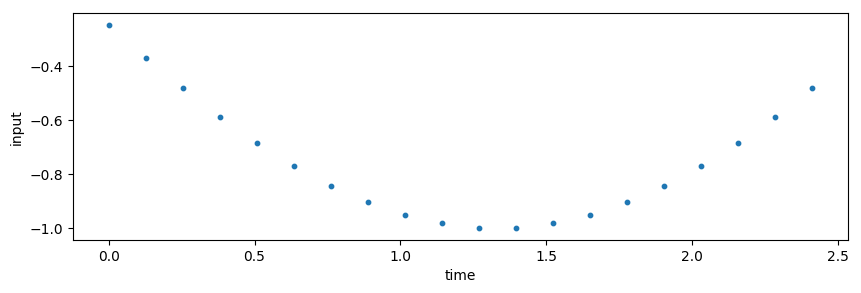

In [20]:
fig = plt.figure(figsize=(10,3), dpi=100, facecolor='w')
ax1 = fig.add_subplot(1,1,1)
plt.xlabel("time")
plt.ylabel("input")
ax1.scatter(x_batch, batch_plot[0], s=10)
plt.show()

In [21]:
fing = chainer.Variable(xp.asarray([batch_plot[j, 0] for j in range(5)], dtype = np.float32)[:, np.newaxis])
fing

variable([[-2.4868989e-01],
          [ 1.2246469e-16],
          [ 1.2533323e-01],
          [ 2.4868989e-01],
          [-9.5105654e-01]])

In [22]:
batch_plot.shape

(5, 20)

予測段階

パラメータ設定

In [0]:
MODEL_PATH = "./model_5.pkl"
PREDICTION_LENGTH = 75
PREDICTION_PATH = "./prediction_5.txt"
INITIAL_PATH = "./initial.txt"
MINI_BATCH_SIZE = 100
LENGTH_OF_SEQUENCE = 100
STEPS_PER_CYCLE = 50
NUMBER_OF_CYCLES = 100

In [0]:
def predict_sequence(model, input_seq, output_seq, dummy):
    sequences_col = len(input_seq)
    model.reset_state()
    for i in range(sequences_col):
        x = chainer.Variable(xp.asarray(input_seq[i:i+1], dtype=np.float32)[:, np.newaxis])
        future = model(x, dummy)
    cpu_future = chainer.cuda.to_cpu(future.data)
    return cpu_future

In [0]:
def predict(seq, model, pre_length, initial_path, prediction_path):
    # initial sequence 
    input_seq = np.array(seq[:seq.shape[0]/4])
 
    output_seq = np.empty(0)
 
    # append an initial value
    output_seq = np.append(output_seq, input_seq[-1])
 
    model.train = False
    dummy = chainer.Variable(xp.asarray([0], dtype=np.float32)[:, np.newaxis])
 
    for i in range(pre_length):
        future = predict_sequence(model, input_seq, output_seq, dummy)
        input_seq = np.delete(input_seq, 0)
        input_seq = np.append(input_seq, future)
        output_seq = np.append(output_seq, future)
 
    with open(prediction_path, "w") as f:
        for (i, v) in enumerate(output_seq.tolist(), start=input_seq.shape[0]):
            f.write("{i} {v}\n".format(i=i-1, v=v))
 
    with open(initial_path, "w") as f:
        for (i, v) in enumerate(seq.tolist()):
            f.write("{i} {v}\n".format(i=i, v=v))

予測モデル構築

In [26]:
# load model
model = pickle.load(open(MODEL_PATH))

# make data
data_maker = DataMaker(steps_per_cycle=STEPS_PER_CYCLE, number_of_cycles=NUMBER_OF_CYCLES)
data = data_maker.make()
sequences = data_maker.make_mini_batch(data, mini_batch_size=MINI_BATCH_SIZE, length_of_sequence=LENGTH_OF_SEQUENCE)

sample_index = 45
predict(sequences[sample_index], model, PREDICTION_LENGTH, INITIAL_PATH, PREDICTION_PATH)#sample_index個目のミニバッチのみ引数にわたす

FileNotFoundError: ignored